In [76]:
import numpy as np


class GrapheneContinuumModel:
    """Continuum model for a BLG system."""

    # Pauli matrices
    s0 = np.array([[1, 0], [0, 1]], dtype=complex)
    s1 = np.array([[0, 1], [1, 0]], dtype=complex)
    s2 = np.array([[0, -1j], [1j, 0]], dtype=complex)
    s3 = np.array([[1, 0], [0, -1]], dtype=complex)

    def __init__(self, t1=2.7, dCC=1.42, tperp=0.4):
        self.t1 = t1
        self.dCC = dCC
        self.tperp = tperp
        self.hbar_vF = 3 * t1 * dCC / 2

    def M_BLG_Dirac(self, k, Kpoint: str):
        """AB bilayer graphene (with k expanded from Dirac points)"""
        kx, ky = k

        Minter = (
            self.tperp / 2 * (np.kron(self.s1, self.s1) - np.kron(self.s2, self.s2))
        )

        if Kpoint == "K":
            Mintra = self.hbar_vF * (
                kx * np.kron(self.s0, self.s1) + ky * np.kron(self.s0, self.s2)
            )
            return Mintra + Minter
        elif Kpoint == "Kp":
            Mintra = self.hbar_vF * (
                -kx * np.kron(self.s0, self.s1) + ky * np.kron(self.s0, self.s2)
            )
            return Mintra + Minter
        else:
            raise ValueError("Incorrect Kpoint. Must be 'K' or 'Kp'.")

    def M_bias(self, V0):
        """Bias function."""
        return V0 * np.kron(self.s3, self.s0)

    def M_SL(self, VSL, alpha):
        """Superlattice potential function."""
        return (
            VSL
            / 2
            * (
                np.kron(self.s0 + self.s3, self.s0)
                + alpha * np.kron(self.s0 - self.s3, self.s0)
            )
        )

    def create_Hbias(self, V0, list_Q):
        MV0 = self.M_bias(V0)

        dim = 4 * len(list_Q)
        Hbias = np.zeros((dim, dim), dtype=complex)

        for i in range(len(list_Q)):
            i_start = i * 4
            i_end = i_start + 4

            Hbias[i_start:i_end, i_start:i_end] += MV0

        return Hbias

    def create_HSL(self, VSL, alpha, ind_nondiag):
        MSL = self.M_SL(VSL, alpha)
        dim = 4 * len(ind_nondiag)
        HSL = np.zeros((dim, dim), dtype=complex)

        for row in range(len(ind_nondiag)):
            row_start = row * 4
            row_end = row_start + 4

            for col in ind_nondiag[row]:
                col_start = col * 4
                col_end = col_start + 4

                HSL[row_start:row_end, col_start:col_end] += MSL

        return HSL

    def create_HBLG_Dirac(self, k, list_Q, Kpoint):
        dim = 4 * len(list_Q)
        HBLG = np.zeros((dim, dim), dtype=complex)

        for i in range(len(list_Q)):
            i_start = i * 4
            i_end = i_start + 4

            MBLG = self.M_BLG_Dirac(k + list_Q[i], Kpoint)

            HBLG[i_start:i_end, i_start:i_end] += MBLG

        return HBLG


def En_kpath_2D(H2D, kpath, nbands=None):
    if nbands is None:
        nbands = H2D(0, 0).shape[0]

    En_kpath = np.zeros((len(kpath), nbands))

    for i, (kx, ky) in enumerate(kpath):
        H = H2D(kx, ky)
        En = np.sort(np.real(np.linalg.eigvals(H)))[:nbands]
        En_kpath[i, :] = En

    return En_kpath


def interpolate_path(points, total_points=100):
    distances = [distance(points[i], points[i+1]) for i in range(len(points)-1)]
    total_distance = sum(distances)

    path = []
    k_point_indices = [0]
    current_index = 0

    for i in range(len(points) - 1):
        segment_distance = distances[i]
        segment_points = round(total_points * (segment_distance / total_distance))

        for t in np.linspace(0, 1, segment_points):
            path.append(points[i] * (1 - t) + points[i + 1] * t)
            current_index += 1

        k_point_indices.append(current_index - 1)

    return np.array(path), k_point_indices


def create_Qn(L):
    """Create the Q vectors for the superlattice potential."""
    Q = 2 * np.pi / L
    return [
        Q * np.array([np.cos(2 * np.pi * n / 6), np.sin(2 * np.pi * n / 6)])
        for n in range(1, 7)
    ]


def create_listQ(Qn, NNorder):
    """Create the list of Q vectors for the superlattice potential."""
    list_Q = [np.array([0.0, 0.0])]
    list_len = [0, 1]  # list_len[0] = 0 and list_len[1] = 1

    ind_nondiag = []

    for it_NNorder in range(1, NNorder + 1):
        start_idx = list_len[it_NNorder - 1]
        end_idx = list_len[it_NNorder]

        for it_Q in range(start_idx, end_idx):
            Qs_it = [list_Q[it_Q] + Q for Q in Qn]

            ind_it = []
            for Q in Qs_it:
                append_if_not_present(list_Q, Q)

                ind = find_first(list_Q, Q)
                ind_it.append(ind)
            ind_nondiag.append(ind_it)

        list_len.append(len(list_Q))

    for it_Q in range(list_len[-2], list_len[-1]):
        Qs_it = [list_Q[it_Q] + Q for Q in Qn]

        ind_it = []
        for Q in Qs_it:
            ind = find_first(list_Q, Q)
            if ind is not None:
                ind_it.append(ind)
        ind_nondiag.append(ind_it)

    return list_Q, ind_nondiag


def append_if_not_present(list_of_vectors, new_vector, atol=1e-8):
    for vec in list_of_vectors:
        if np.allclose(vec, new_vector, atol=atol):
            return list_of_vectors  # If already present, return the original list
    list_of_vectors.append(new_vector)
    return list_of_vectors


def find_first(list_of_vectors, target_vector, atol=1e-8):
    return next(
        (
            i
            for i, vec in enumerate(list_of_vectors)
            if np.allclose(vec, target_vector, atol=atol)
        ),
        None,
    )


def distance(p1, p2):
    return np.linalg.norm(p2 - p1)

In [89]:
# Parameters
L = 500
alpha = 0.3
VSL = 0.010
V0 = 0.0
NNorder = 2

# Instantiate the model
model = GrapheneContinuumModel()

# Build Hamiltonian
Qn = create_Qn(L)
list_Q, ind_nondiag = create_listQ(Qn, NNorder)
Hbias = model.create_Hbias(V0, list_Q)
HSL = model.create_HSL(VSL, alpha, ind_nondiag)


def HBLG_K(k):
    return model.create_HBLG_Dirac(k, list_Q, "K")


def HBLG_Kp(k):
    return model.create_HBLG_Dirac(k, list_Q, "Kp")


def Htot_K(kx, ky):
    return Hbias + HSL + HBLG_K([kx, ky])


def Htot_Kp(kx, ky):
    return Hbias + HSL + HBLG_Kp([kx, ky])

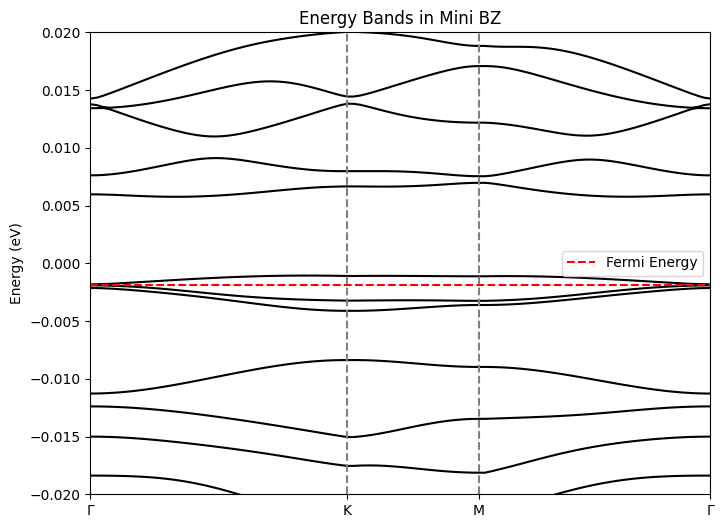

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Generate high-symmetry points in the mini Brillouin zone (BZ)
b1, b2 = Qn[0], Qn[1]
Gamma = np.array([0.0, 0.0])
M = b1 / 2
K = (b1 + b2) / 3

# Define the path through the mini BZ
path_points = [Gamma, K, M, Gamma]

# Generate the k-path and get indices for special K points
kpath, k_point_indices = interpolate_path(path_points, total_points=100)

# Calculate the energy bands along the path in the BZ
En_K_kpath = En_kpath_2D(Htot_K, kpath)

# Calculate the Fermi energy (EF)
nbands = En_K_kpath.shape[1]
mid_band = int(nbands / 2)
EF = (np.min(En_K_kpath[:, mid_band]) + np.max(En_K_kpath[:, mid_band - 1])) / 2

# Plot the energy bands
plt.figure(figsize=(8, 6))
for i in range(nbands):
    plt.plot(En_K_kpath[:, i], color='black')

plt.axhline(y=EF, color='red', linestyle='--', label='Fermi Energy')

# Add vertical lines and tick marks for special K points
for idx in k_point_indices[1:-1]:
    plt.axvline(x=idx, color='gray', linestyle='--')

special_points = ['Γ', 'K', 'M', 'Γ']
plt.xticks(ticks=k_point_indices, labels=special_points)

plt.ylim([-0.02, 0.02])
plt.xlim([0, k_point_indices[-1]])
plt.ylabel('Energy (eV)')
plt.title('Energy Bands in Mini BZ')
plt.legend()
plt.show()